In [1]:
"""
Created on Apr 17 2023

@author: rodrigo pena
"""

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['savefig.dpi'] = 120
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef

torch.manual_seed(0)

import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix

device = torch.device("cpu")
# device = torch.device("cuda:0") # Uncomment this to run on GPU


In [2]:
ls

classify_IFFL_IFFL_NL.ipynb  iffl_vs_iffl_lbs.dat     nfbl_vs_nfbl_signal.dat
classify_IFFL_NFBL.ipynb     iffl_vs_iffl_signal.dat  nl_lbs.dat
classify_IFFL_NFBL_NL.ipynb  M1_R1_lbs.dat            nl_signal.dat
classify_NFLB_NFBL_NL.ipynb  M1_R1_signal.dat
gendata_IFFL_NFBL.ipynb      nfbl_vs_nfbl_lbs.dat


In [3]:
torch.cuda.is_available()

False

In [4]:
data_cxy = np.loadtxt("nfbl_vs_nfbl_signal.dat").astype(np.float32)
label_cxy = np.loadtxt("nfbl_vs_nfbl_lbs.dat").astype(np.float32)
data_cxy = torch.from_numpy(data_cxy)
label_cxy = torch.from_numpy(label_cxy)

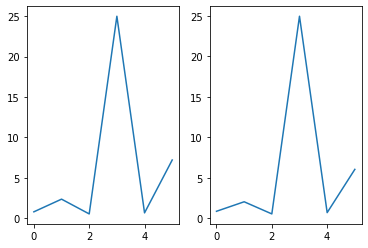

In [5]:
plt.subplot(121)
plt.plot(data_cxy[6])
plt.subplot(122)
plt.plot(data_cxy[7])

In [6]:
data_cxy[:10]

tensor([[ 0.8940,  3.6700,  0.5812, 24.9700,  0.7363,  6.5000],
        [ 0.9236,  3.1900,  0.5598, 24.9700,  0.7403,  5.6200],
        [ 0.9339,  3.4500,  0.7172, 24.9600,  0.8250,  7.5100],
        [ 0.9515,  3.1300,  0.6080, 24.9600,  0.7783, 12.7700],
        [ 0.8502,  2.8900,  0.6828, 24.9700,  0.7645,  9.5500],
        [ 0.8723,  3.3800,  0.6440, 24.9700,  0.7599,  9.0300],
        [ 0.8048,  2.3700,  0.5448, 24.9800,  0.6744,  7.2100],
        [ 0.8422,  2.0200,  0.5172, 24.9800,  0.6778,  6.0300],
        [ 0.8934,  2.6100,  0.6901, 24.9800,  0.7883,  7.0400],
        [ 0.9588,  2.8500,  0.6241, 24.9700,  0.7917,  4.7400]])

In [7]:
class Net(nn.Module):
    def __init__(self,D_in,H,D_out):
        super(Net,self).__init__()
        self.linear1 = nn.Linear(D_in,H)
        self.linear2 = nn.Linear(H,D_out)
        
    def forward(self,x):
        x = torch.tanh(self.linear1(x))
        x = self.linear2(x)
        return x

class Net_relu(nn.Module):
    def __init__(self,D_in,H,D_out):
        super(Net_relu,self).__init__()
        self.linear1 = nn.Linear(D_in,H)
        self.linear2 = nn.Linear(H,D_out)
        
    def forward(self,x):
        x = torch.relu(self.linear1(x))
        x = self.linear2(x)
        return x
    
class Net_sigmoid(nn.Module):
    def __init__(self,D_in,H,D_out):
        super(Net_sigmoid,self).__init__()
        self.linear1 = nn.Linear(D_in,H)
        self.linear2 = nn.Linear(H,D_out)
        
    def forward(self,x):
        x = torch.sigmoid(self.linear1(x))
        x = self.linear2(x)
        return x    

In [8]:
input_dim = len(data_cxy[0])
output_dim = 2
learning_rate=0.01
# compare lr with real spk trains
H=10
epochs = 50

model = Net(input_dim,H,output_dim)
optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate, momentum=0.2)
criterion = nn.CrossEntropyLoss()
print(model)

Net(
  (linear1): Linear(in_features=6, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=2, bias=True)
)


In [9]:
# Print the parameters

print('W: ',list(model.parameters())[0].size())
print('b: ',list(model.parameters())[1].size())

W:  torch.Size([10, 6])
b:  torch.Size([10])


In [10]:
my_data_train = []
my_data_val = []
for i in range(len(data_cxy)):
    if i < len(data_cxy)*0.75:
        my_data_train.append([data_cxy[i], label_cxy[i].type(torch.LongTensor)])
    else:    
        my_data_val.append([data_cxy[i], label_cxy[i].type(torch.LongTensor)])

train_set = torch.utils.data.DataLoader(dataset=my_data_train,shuffle=True,batch_size=250)
val_set = torch.utils.data.DataLoader(dataset=my_data_val,shuffle=True,batch_size=250)

In [11]:
len(val_set)

4

# tanh

In [12]:
loss_list = []
accuracy_list = []
N_test = len(my_data_val)
epochs = 2000

def train_model(n_epochs):
    for epoch in range(n_epochs):
#         print(epoch)
        for x,y in train_set:
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z,y)
            loss.backward()
            optimizer.step()
        correct = 0
        for x_test, y_test in val_set:
            z = model(x_test)
            _, yhat = torch.max(z.data,1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        loss_list.append(loss.data)
        accuracy_list.append(accuracy)
train_model(epochs)

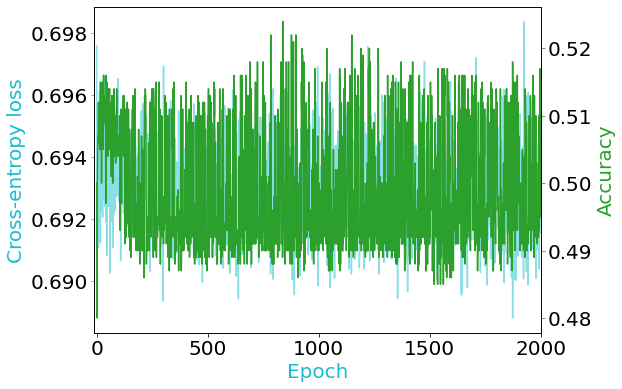

In [13]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots(figsize=(8, 6))
color = 'tab:cyan'
ax1.plot(loss_list,color=color,alpha=0.5)
ax1.set_xlabel('Epoch',color=color)
ax1.set_ylabel('Cross-entropy loss',color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:green'
ax2.set_ylabel('Accuracy', color=color)  
ax2.plot( accuracy_list, color=color,alpha=1)
ax2.tick_params(axis='y', color=color)
# fig.tight_layout()
plt.xlim([-10,epochs])
plt.locator_params(axis='x', nbins=8)
for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
             ax1.get_xticklabels() + ax1.get_yticklabels() + 
            [ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
             ax2.get_xticklabels() + ax2.get_yticklabels()):
    item.set_fontsize(20)

# plt.savefig('tanh.png')
# plt.savefig('tanh.eps')

In [14]:
accuracy_list[-1]

0.495

# ReLU

In [15]:
input_dim = len(data_cxy[0])
output_dim = 2
learning_rate=0.01
# compare lr with real spk trains
H=10
# epochs = 50

model = Net_relu(input_dim,H,output_dim)
optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate, momentum=0.2)
criterion = nn.CrossEntropyLoss()
print(model)

Net_relu(
  (linear1): Linear(in_features=6, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=2, bias=True)
)


In [16]:
loss_list = []
accuracy_list = []
N_test = len(my_data_val)

def train_model(n_epochs):
    for epoch in range(n_epochs):
        for x,y in train_set:
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z,y)
            loss.backward()
            optimizer.step()
            
        correct = 0
        for x_test, y_test in val_set:
            z = model(x_test)
            _, yhat = torch.max(z.data,1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        loss_list.append(loss.data)
        accuracy_list.append(accuracy)
train_model(epochs)

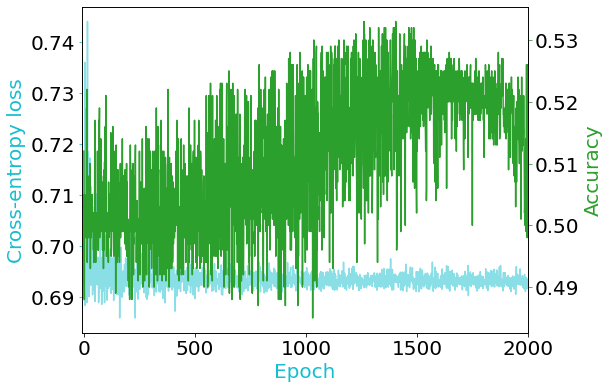

In [17]:

# Plot the loss and accuracy

fig, ax1 = plt.subplots(figsize=(8, 6))
color = 'tab:cyan'
ax1.plot(loss_list,color=color,alpha=0.5)
ax1.set_xlabel('Epoch',color=color)
ax1.set_ylabel('Cross-entropy loss',color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:green'
ax2.set_ylabel('Accuracy', color=color)  
ax2.plot( accuracy_list, color=color,alpha=1)
ax2.tick_params(axis='y', color=color)
# fig.tight_layout()
plt.xlim([-10,epochs])
plt.locator_params(axis='x', nbins=8)
for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
             ax1.get_xticklabels() + ax1.get_yticklabels() + 
            [ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
             ax2.get_xticklabels() + ax2.get_yticklabels()):
    item.set_fontsize(20)

# plt.savefig('ghs_relu.png')
# plt.savefig('ghs_relu.eps')

In [18]:
accuracy_list[-1]

0.526

# Sigmoid

In [19]:
input_dim = len(data_cxy[0])
output_dim = 2
learning_rate=0.01
# compare lr with real spk trains
H=10
# epochs = 50

model = Net_sigmoid(input_dim,H,output_dim)
optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate, momentum=0.2)
criterion = nn.CrossEntropyLoss()
print(model)

Net_sigmoid(
  (linear1): Linear(in_features=6, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=2, bias=True)
)


In [20]:
loss_list = []
accuracy_list = []
N_test = len(my_data_val)

def train_model(n_epochs):
    for epoch in range(n_epochs):
        for x,y in train_set:
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z,y)
            loss.backward()
            optimizer.step()
            
        correct = 0
        for x_test, y_test in val_set:
            z = model(x_test)
            _, yhat = torch.max(z.data,1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        loss_list.append(loss.data)
        accuracy_list.append(accuracy)
train_model(epochs)

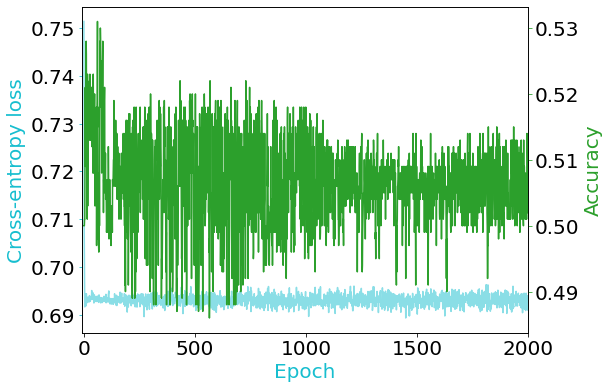

In [21]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots(figsize=(8, 6))
color = 'tab:cyan'
ax1.plot(loss_list,color=color,alpha=0.5)
ax1.set_xlabel('Epoch',color=color)
ax1.set_ylabel('Cross-entropy loss',color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:green'
ax2.set_ylabel('Accuracy', color=color)  
ax2.plot( accuracy_list, color=color,alpha=1)
ax2.tick_params(axis='y', color=color)
# fig.tight_layout()
plt.xlim([-10,epochs])
plt.locator_params(axis='x', nbins=8)
for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
             ax1.get_xticklabels() + ax1.get_yticklabels() + 
            [ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
             ax2.get_xticklabels() + ax2.get_yticklabels()):
    item.set_fontsize(20)

# plt.savefig('ghs_sigmoid.png')
# plt.savefig('ghs_sigmoid.eps')

In [22]:
accuracy_list[-1]

0.502